In [178]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit
from uncertainties import ufloat
from MSquared_methods import remove_wings, get_Wx2

plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
color = "#0097d8"

In [167]:
def normalize(A):
    return (A - np.min(A)) / (np.max(A) - np.min(A))

In [282]:
dx, dy = 5.3E-3, 5.3E-3 # mm
raw = True

In [283]:
if raw: filename = "Data/85-0mA_raw_navaja.csv"
else: filename = "Data/85-0mA_filtrado_navaja.csv"
df = pd.read_csv(filename)

In [284]:
x_razor = np.array(df["absolute_position[mm]"]) # mm
x_razor = x_razor - x_razor[0]
translation_step = x_razor[1]

if raw:
    kernel_length, comparison_length, error = 2, 2, 1E-3
else:
    kernel_length, comparison_length, error = 2, 2, 4E-3

intensity = np.array(df["intensity[mW]"]) # mW
intensity = normalize(intensity)
intensity_gradient = np.gradient(intensity, translation_step)
intensity_gradient, left_limit, right_limit = remove_wings(intensity_gradient, kernel_length, comparison_length, error)
intensity_gradient = intensity_gradient / trapezoid(intensity_gradient, dx=translation_step)
clipped_x_razor = x_razor[left_limit:right_limit]


# Center of mass
x0_razor = trapezoid(clipped_x_razor * intensity_gradient, dx=translation_step)
# Standard deviation squared
sigma2_x = trapezoid((clipped_x_razor - x0_razor)**2 * intensity_gradient, dx=translation_step)
# Waist squared
Wx2_razor = 4 * sigma2_x

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


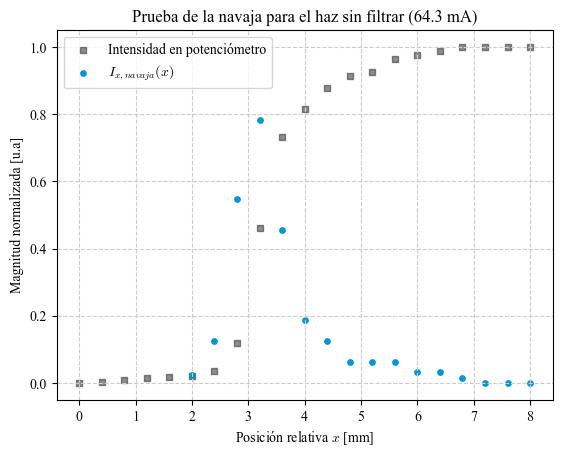

In [285]:
if raw:
    title = "Prueba de la navaja para el haz sin filtrar (64.3 mA)"
    filename = "Figures/Raw_Razor.png"
else:
    title = "Prueba de la navaja para el haz filtrado (85.0 mA)"
    filename = "Figures/Filtered_Razor.png"

fig, ax = plt.subplots()

ax.scatter(x_razor, intensity, color="#1c1f1b", alpha=0.5, s=15, marker="s", label="Intensidad en potenciómetro")
ax.scatter(clipped_x_razor, intensity_gradient, color=color, s=15, label="$I_{{x, navaja}}(x)$")

ax.grid(True, ls="--", color="#ccc")
ax.set(title=title, xlabel="Posición relativa $x$ [mm]",
       ylabel="Magnitud normalizada [u.a]")
ax.legend()
plt.savefig(filename, dpi=300)
plt.show()

In [286]:
if raw:
    im_filename = "Data/85-0mA_raw_0-07ms_233offset.tif"
    kernel_length, comparison_length, error = 50, 12, 1E-4
    
else:
    im_filename = "Data/85-0mA_filtrado_0-07ms_233offset.tif"
    kernel_length, comparison_length, error = 50, 12, 5E-4
imarray = np.array(Image.open(im_filename))

og_x = dx * np.arange(0, imarray.shape[1], 1)

Wx2_im, x0, x, marginals, og_marginals = get_Wx2(imarray, og_x, dx, dy,
                                                 kernel_length, comparison_length, error)

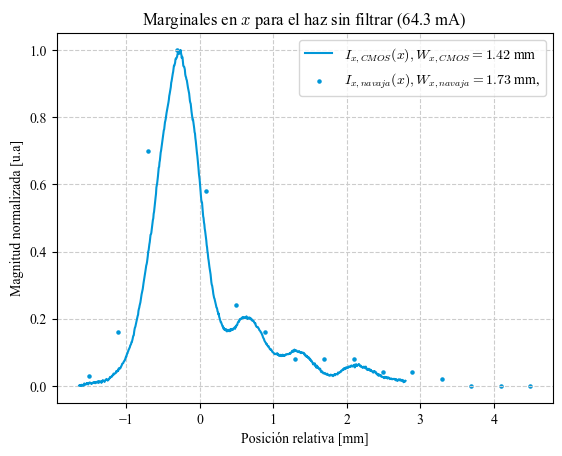

In [287]:
marginals = normalize(marginals)
intensity_gradient = normalize(intensity_gradient)

if raw:
    title = "Marginales en $x$ para el haz sin filtrar (64.3 mA)"
    filename = "Figures/Raw_RazorvsCMOS.png"
else:
    title = "Marginales en $x$ para el haz filtrado (85.0 mA)"
    filename = "Figures/Filtered_RazorvsCMOS.png"

fig, ax = plt.subplots()
ax.plot(x - x0, marginals, color=color,
       label=f"$I_{{x, CMOS}}(x), W_{{x, CMOS}} = {np.sqrt(Wx2_im):.2f}$ mm")
ax.scatter(clipped_x_razor - x0_razor, intensity_gradient, color=color,
           label=f"$I_{{x, navaja}}(x), W_{{x, navaja}} = {np.sqrt(Wx2_razor):.2f}$ mm, ", s=5)

ax.set(title=title, xlabel="Posición relativa [mm]", ylabel="Magnitud normalizada [u.a]")
ax.legend(fontsize=10)
ax.grid(True, ls="--", color="#ccc")

plt.savefig(filename, dpi=200)
plt.show()

In [288]:
def percent_error(A, B):
    return 100 * np.abs(A - B) / np.abs(np.mean((A, B)))

In [289]:
percent_error(np.sqrt(Wx2_im), np.sqrt(Wx2_razor))

19.746830516037353